# 使用债券数据来制作债券池的可视化

In [429]:
import pandas as pd
import numpy as np
import json
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# 数据预处理

In [430]:
df_bond_basic = pd.read_csv('static/bond_basic_info_sheet.csv')
feature = ['bond_cd', 'bond_cn_full_nm', 'bond_cn_shrt_nm', 'scrty_term', 'crcltn_size', 'bond_tp_nm', 'indstry_nm', 'indstry_sbcls_nm']
df_bond_basic_filter = df_bond_basic[feature]
df_bond_basic_filter['crcltn_size'] = df_bond_basic_filter['crcltn_size']/100000000
df_bond_basic_filter['crcltn_size_sqrt'] = np.sqrt(df_bond_basic_filter['crcltn_size'])
df_bond_basic_filter['indstry_nm'].fillna('其他行业', inplace=True)
df_bond_basic_filter['indstry_sbcls_nm'].fillna('其他sbcls行业', inplace=True)
df_bond_basic_filter = df_bond_basic_filter.drop_duplicates(subset='bond_cd')
print(df_bond_basic_filter)

           bond_cd                                bond_cn_full_nm  \
0        2305528.0                        2023年江苏省地方政府再融资专项债券(四期)   
1      102381121.0                  南京扬子国资投资集团有限责任公司2023年度第一期中期票据   
2         230205.0                             国家开发银行2023年第五期金融债券   
5         230012.0                              2023年记账式附息(十二期)国债   
21       2305622.0  2023年浙江省其他项目收益专项债券(二十二期)-2023年浙江省政府专项债券(三十四期)   
...            ...                                            ...   
29237     170018.0                              2017年记账式附息(十八期)国债   
29666     180011.0                              2018年记账式附息(十一期)国债   
29752     180013.0                              2018年记账式附息(十三期)国债   
29856     180020.0                              2018年记账式附息(二十期)国债   
29890     180019.0                              2018年记账式附息(十九期)国债   

      bond_cn_shrt_nm scrty_term  crcltn_size bond_tp_nm indstry_nm  \
0             23江苏债16        20年       110.59      地方政府债       其他行业   
1        23扬子国资MTN001        

/var/folders/gj/bwfyx1ks0p17lbgn6fl1nx1c0000gp/T/ipykernel_4929/3070006363.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bond_basic_filter['crcltn_size'] = df_bond_basic_filter['crcltn_size']/100000000
/var/folders/gj/bwfyx1ks0p17lbgn6fl1nx1c0000gp/T/ipykernel_4929/3070006363.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bond_basic_filter['crcltn_size_sqrt'] = np.sqrt(df_bond_basic_filter['crcltn_size'])
/var/folders/gj/bwfyx1ks0p17lbgn6fl1nx1c0000gp/T/ipykernel_4929/3070006363.py:6: Setti

# 数据清洗
计算 scrty_term 列的计数分布。
找到前百分之80的 scrty_term 计数。
将前百分之80的 scrty_term 计数与 DataFrame 进行匹配，并为匹配的行创建一个新列。
将后百分之20的 scrty_term 计数归类为 "其他期限"。

In [431]:
def classify_top_percent(df, column_name, new_column_name, new_name, percentile=0.8):
    """
    将指定列的计数分布按照指定的百分比阈值分类，创建一个新列，并根据条件填充值。
    
    参数：
    df (DataFrame)：输入的 DataFrame。
    column_name (str)：要进行计数分布的列名。
    new_column_name (str)：新列的列名。
    new_name (str)：新列中用于表示符合条件的值的名称。
    percentile (float)：百分比阈值，默认为0.8。
    
    返回：
    DataFrame：修改后的 DataFrame。
    """
    # 计算指定列的计数分布
    counts = df.groupby(column_name).size()
    
    # 找到前百分之80的计数
    top_percent_counts = counts.quantile(percentile)
    
    # 选择前百分之80的值
    top_values = counts[counts >= top_percent_counts].index.tolist()
    
    # 创建新列，根据条件填充值
    df[new_column_name] = df[column_name].apply(lambda x: x if x in top_values else new_name)
    
    return df

In [432]:
df_bond_basic_filter = classify_top_percent(df_bond_basic_filter, 'scrty_term', 'new_scrty_term', '其他期限', percentile=0.95)
# df_bond_basic_filter = classify_top_percent(df_bond_basic_filter, 'bond_tp_nm', 'new_bond_tp_nm', '其他债券类型', percentile=0.6)
# df_bond_basic_filter = classify_top_percent(df_bond_basic_filter, 'indstry_sbcls_nm', 'new_indstry_sbcls_nm', '其他sbcls行业', percentile=0.8)
# df_bond_basic_filter = classify_top_percent(df_bond_basic_filter, 'scrty_term', 'new_scrty_term', '其他期限', percentile=0.8)
# df_bond_basic_filter.to_csv("df_bond_basic_filter.csv")
# df = df_bond_basic_filter

# Tree
期限
债券类型
行业
债券名称

期限
债券名称

债券类型
债券名称

In [433]:
import json

def create_tree(data, category, target_values):
    tree = {"name": "root", target_values: 0, "children": []}

    for row in data:
        current_level = tree["children"]
        for idx, level_name in enumerate(category):
            value = row[level_name]
            if idx < len(category) - 1:
                match = next((item for item in current_level if item["name"] == value), None)
                if match:
                    current_level = match["children"]
                else:
                    new_node = {"name": value, target_values: 0, "category": level_name, "children": []}
                    current_level.append(new_node)
                    current_level = new_node["children"]
            else:  # 最后一个层级
                match = next((item for item in current_level if item["name"] == value), None)
                if match:
                    current_level = match["children"]
                else:
                    new_node = {"name": value, target_values: row["volume"], "category": level_name, "children": []}
                    current_level.append(new_node)

    # 计算每个节点的 value
    calculate_tree_values(tree, target_values)

    return tree

def calculate_node_value(node, target_values):
    if not node["children"]:
        return node[target_values]
    else:
        node[target_values] = sum(calculate_node_value(child, target_values) for child in node["children"])
        return node[target_values]

def calculate_tree_values(tree, target_values):
    calculate_node_value(tree, target_values)

    for child in tree["children"]:
        calculate_tree_values(child, target_values)

    return tree

# 示例数据
data = [
    {"bond_cd": 1, "volume": 100, "new_scrty_term": "term1", "new_bond_tp_nm": "type1", "new_indstry_sbcls_nm": "subclass1"},
    {"bond_cd": 2, "volume": 200, "new_scrty_term": "term1", "new_bond_tp_nm": "type1", "new_indstry_sbcls_nm": "subclass2"},
    {"bond_cd": 3, "volume": 150, "new_scrty_term": "term1", "new_bond_tp_nm": "type2", "new_indstry_sbcls_nm": "subclass1"},
    {"bond_cd": 4, "volume": 120, "new_scrty_term": "term2", "new_bond_tp_nm": "type1", "new_indstry_sbcls_nm": "subclass1"},
    {"bond_cd": 5, "volume": 180, "new_scrty_term": "term2", "new_bond_tp_nm": "type1", "new_indstry_sbcls_nm": "subclass2"},
]
category = ["new_indstry_sbcls_nm", "new_bond_tp_nm", "new_scrty_term"]
target_values = "volume"
tree = create_tree(data, category, target_values)
print(json.dumps(tree, indent=4))


{
    "name": "root",
    "volume": 750,
    "children": [
        {
            "name": "subclass1",
            "volume": 370,
            "category": "new_indstry_sbcls_nm",
            "children": [
                {
                    "name": "type1",
                    "volume": 220,
                    "category": "new_bond_tp_nm",
                    "children": [
                        {
                            "name": "term1",
                            "volume": 100,
                            "category": "new_scrty_term",
                            "children": []
                        },
                        {
                            "name": "term2",
                            "volume": 120,
                            "category": "new_scrty_term",
                            "children": []
                        }
                    ]
                },
                {
                    "name": "type2",
                    "volume": 150,
         

# 将数据按照两个维度分类存储
bond_tp_nm、scrty_term
new_bond_tp_nm、new_scrty_term

In [434]:
import pandas as pd

# 定义新的顺序列表
scrty_term_order = ['1年', '3年', '5年', '7年', '10年', '30年', '其他期限']

# 创建交叉表
pivot_table = pd.pivot_table(df_bond_basic_filter, index='bond_tp_nm', columns='new_scrty_term', aggfunc='size', fill_value=0)

# 重新排序索引和列标签
pivot_table = pivot_table.reindex(index=df_bond_basic_filter['bond_tp_nm'].unique(), columns=scrty_term_order, fill_value=0)
# 计算每行的总和
row_sums = pivot_table.sum(axis=1)

# 按行总和排序
pivot_table_sorted = pivot_table.loc[row_sums.sort_values(ascending=False).index]
# print(pivot_table_sorted)


# 获取后10行
other_bonds = pivot_table_sorted.iloc[-17:]

# 将这些行合并为一行并取列和
other_bonds_combined = pd.DataFrame(other_bonds.sum(axis=0)).T

# 重命名索引为“其他类型债券”
other_bonds_combined.index = ['其他类型债券']

# 删除原表中的这些行
pivot_table_sorted.drop(other_bonds.index, inplace=True)

# 将合并的行添加到表的末尾
pivot_table_sorted = pd.concat([pivot_table_sorted, other_bonds_combined])

print(pivot_table_sorted)

new_scrty_term   1年   3年   5年  7年  10年  30年  其他期限
中期票据              0  363  283  13    9    0    67
同业存单            422    0    0   0    0    0   248
定向工具              0  166   99   0    2    0    43
超短期融资券            0    0    0   0    0    0   288
地方政府债             0   12   48  45   39    0    85
政策性金融债           14   28   31  24   53    0    22
国债                4    9   15  20   23    0    35
其他类型债券            2  113   87  62  113    0   105


In [435]:
matrix_data = pivot_table_sorted.values.tolist()
matrix_data = pivot_table_sorted.reset_index().values.tolist()
matrix_data.insert(0, [""] + pivot_table_sorted.columns.tolist())

print(matrix_data)

[['', '1年', '3年', '5年', '7年', '10年', '30年', '其他期限'], ['中期票据', 0, 363, 283, 13, 9, 0, 67], ['同业存单', 422, 0, 0, 0, 0, 0, 248], ['定向工具', 0, 166, 99, 0, 2, 0, 43], ['超短期融资券', 0, 0, 0, 0, 0, 0, 288], ['地方政府债', 0, 12, 48, 45, 39, 0, 85], ['政策性金融债', 14, 28, 31, 24, 53, 0, 22], ['国债', 4, 9, 15, 20, 23, 0, 35], ['其他类型债券', 2, 113, 87, 62, 113, 0, 105]]


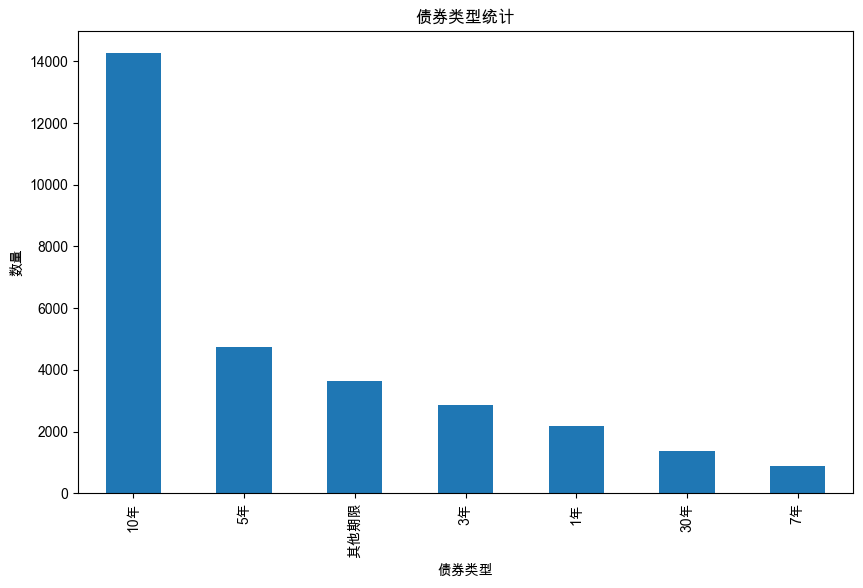

In [436]:
import pandas as pd
import matplotlib.pyplot as plt

# 指定中文字体为系统默认字体
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']
plt.rcParams['axes.unicode_minus'] = False  # 解决保存图像是负号'-'显示为方块的问题

# 假设 df 是你的 DataFrame
# 按 bond_tp_nm 列进行分组，并统计每组中的行数
bond_type_counts = df['new_scrty_term'].value_counts()

# 绘制柱状图
plt.figure(figsize=(10, 6))
bond_type_counts.plot(kind='bar')
plt.title('债券类型统计')
plt.xlabel('债券类型')
plt.ylabel('数量')
plt.show()



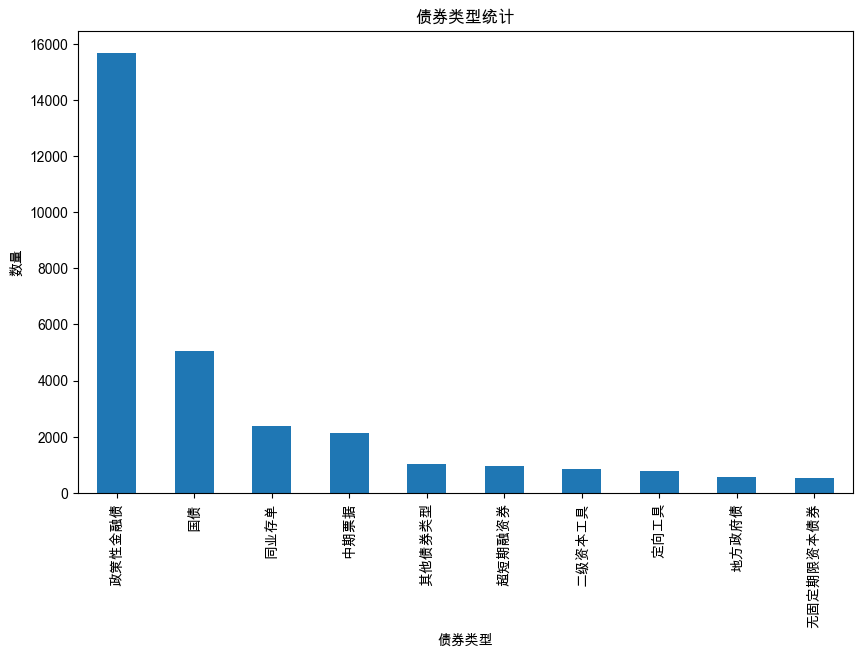

In [437]:
import pandas as pd
import matplotlib.pyplot as plt

# 指定中文字体为系统默认字体
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']
plt.rcParams['axes.unicode_minus'] = False  # 解决保存图像是负号'-'显示为方块的问题

# 假设 df 是你的 DataFrame
# 按 bond_tp_nm 列进行分组，并统计每组中的行数
bond_type_counts = df['new_bond_tp_nm'].value_counts()

# 绘制柱状图
plt.figure(figsize=(10, 6))
bond_type_counts.plot(kind='bar')
plt.title('债券类型统计')
plt.xlabel('债券类型')
plt.ylabel('数量')
plt.show()



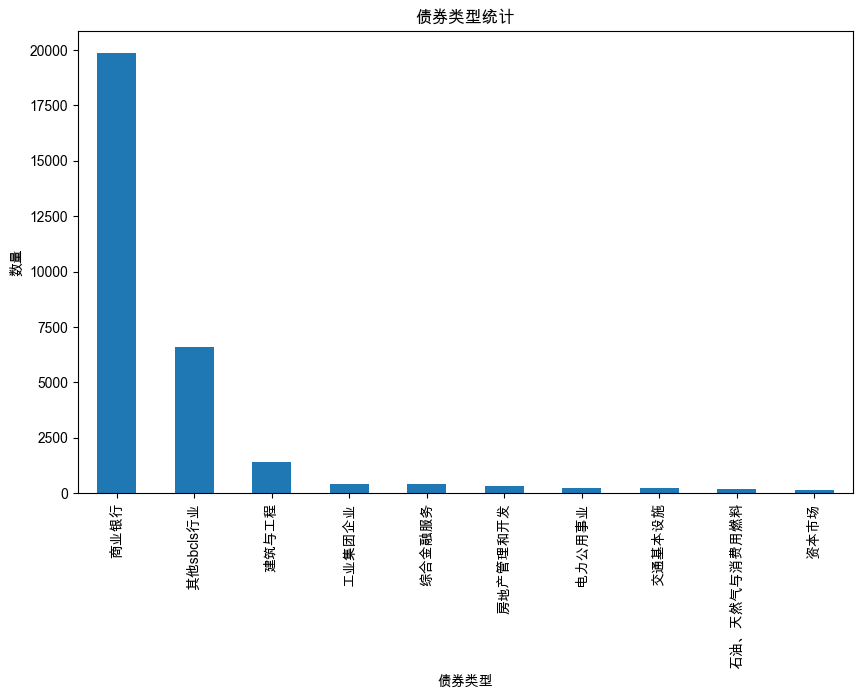

In [438]:

import pandas as pd
import matplotlib.pyplot as plt

# 指定中文字体为系统默认字体
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']
plt.rcParams['axes.unicode_minus'] = False  # 解决保存图像是负号'-'显示为方块的问题

# 假设 df 是你的 DataFrame
# 按 bond_tp_nm 列进行分组，并统计每组中的行数
bond_type_counts = df['new_indstry_sbcls_nm'].value_counts()

# 绘制柱状图
plt.figure(figsize=(10, 6))
bond_type_counts.plot(kind='bar')
plt.title('债券类型统计')
plt.xlabel('债券类型')
plt.ylabel('数量')
plt.show()

In [439]:
import pandas as pd

# 定义新的顺序列表
scrty_term_order = ['1年', '3年', '5年', '7年', '10年', '30年', '其他期限']

# 创建交叉表
pivot_table = pd.pivot_table(df_bond_basic_filter, index='bond_tp_nm', columns='new_scrty_term', aggfunc='size', fill_value=0)

# 重新排序索引和列标签
pivot_table = pivot_table.reindex(index=df_bond_basic_filter['bond_tp_nm'].unique(), columns=scrty_term_order, fill_value=0)
# 计算每行的总和
row_sums = pivot_table.sum(axis=1)

# 按行总和排序
pivot_table_sorted = pivot_table.loc[row_sums.sort_values(ascending=False).index]
# print(pivot_table_sorted)

# 获取后10行
other_bonds = pivot_table_sorted.iloc[-16:]

# 将这些行合并为一行并取列和
other_bonds_combined = pd.DataFrame(other_bonds.sum(axis=0)).T

# 重命名索引为“其他类型债券”
other_bonds_combined.index = ['其他类型债券']

# 删除原表中的这些行
pivot_table_sorted.drop(other_bonds.index, inplace=True)

# 将合并的行添加到表的末尾
pivot_table_sorted = pd.concat([pivot_table_sorted, other_bonds_combined])

print(pivot_table_sorted)

new_scrty_term   1年   3年   5年  7年  10年  30年  其他期限
中期票据              0  363  283  13    9    0    67
同业存单            422    0    0   0    0    0   248
定向工具              0  166   99   0    2    0    43
超短期融资券            0    0    0   0    0    0   288
地方政府债             0   12   48  45   39    0    85
政策性金融债           14   28   31  24   53    0    22
国债                4    9   15  20   23    0    35
二级资本工具            0    0    0   0   94    0     2
其他类型债券            2  113   87  62   19    0   103


In [440]:
import pandas as pd
import numpy as np

def classify_top_percent(df, column_name, new_column_name, new_name, percentile=0.8):
    """
    将指定列的计数分布按照指定的百分比阈值分类，创建一个新列，并根据条件填充值。
    
    参数：
    df (DataFrame)：输入的 DataFrame。
    column_name (str)：要进行计数分布的列名。
    new_column_name (str)：新列的列名。
    new_name (str)：新列中用于表示符合条件的值的名称。
    percentile (float)：百分比阈值，默认为0.8。
    
    返回：
    DataFrame：修改后的 DataFrame。
    """
    # 计算指定列的计数分布
    counts = df.groupby(column_name).size()
    
    # 找到前百分之80的计数
    top_percent_counts = counts.quantile(percentile)
    
    # 选择前百分之80的值
    top_values = counts[counts >= top_percent_counts].index.tolist()
    
    # 创建新列，根据条件填充值
    df[new_column_name] = df[column_name].apply(lambda x: x if x in top_values else new_name)
    
    return df

def merge_and_label_others(df, index_column, column_column, order_list, other_rows):
    # 创建交叉表
    pivot_table = pd.pivot_table(df, index=index_column, columns=column_column, aggfunc='size', fill_value=0)

    # 重新排序索引和列标签
    pivot_table = pivot_table.reindex(index=df[index_column].unique(), columns=order_list, fill_value=0)
    
    # 计算每行的总和
    row_sums = pivot_table.sum(axis=1)

    # 按行总和排序
    pivot_table_sorted = pivot_table.loc[row_sums.sort_values(ascending=False).index]

    # 获取后N行
    other_bonds = pivot_table_sorted.iloc[-other_rows:]

    # 将这些行合并为一行并取列和
    other_bonds_combined = pd.DataFrame(other_bonds.sum(axis=0)).T

    # 重命名索引为“其他类型债券”
    other_bonds_combined.index = ['其他类型债券']

    # 删除原表中的这些行
    pivot_table_sorted.drop(other_bonds.index, inplace=True)

    # 将合并的行添加到表的末尾
    pivot_table_sorted = pd.concat([pivot_table_sorted, other_bonds_combined])

    return pivot_table_sorted


In [441]:
df_bond_basic = pd.read_csv('static/bond_basic_info_sheet.csv')
feature = ['bond_cd', 'bond_cn_full_nm', 'bond_cn_shrt_nm', 'scrty_term', 'crcltn_size', 'bond_tp_nm', 'indstry_nm', 'indstry_sbcls_nm']
df_bond_basic_filter = df_bond_basic[feature]
df_bond_basic_filter = classify_top_percent(df_bond_basic_filter, 'scrty_term', 'new_scrty_term', '其他期限', percentile=0.95)

/var/folders/gj/bwfyx1ks0p17lbgn6fl1nx1c0000gp/T/ipykernel_4929/1872779910.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[new_column_name] = df[column_name].apply(lambda x: x if x in top_values else new_name)


In [442]:
scrty_term_order = ['1年', '3年', '5年', '7年', '10年', '30年', '其他期限']
bond_sheet = merge_and_label_others(df_bond_basic_filter, 'bond_tp_nm', 'scrty_term', scrty_term_order, 16)
matrix_data = bond_sheet.values.tolist()
matrix_data = bond_sheet.reset_index().values.tolist()
matrix_data.insert(0, [""] + bond_sheet.columns.tolist())

In [443]:
selected_data = df_bond_basic_filter[(df_bond_basic_filter['new_scrty_term'] == '10年') & 
                                         (df_bond_basic_filter['bond_tp_nm'] == '国债')]
print(selected_data)

        bond_cd     bond_cn_full_nm bond_cn_shrt_nm scrty_term   crcltn_size  \
5      230012.0   2023年记账式附息(十二期)国债        23附息国债12        10年  2.521600e+11   
54     230012.0   2023年记账式附息(十二期)国债        23附息国债12        10年  2.521600e+11   
75     210009.0    2021年记账式附息(九期)国债        21附息国债09        10年  3.186100e+11   
78     230012.0   2023年记账式附息(十二期)国债        23附息国债12        10年  2.521600e+11   
82     230004.0    2023年记账式附息(四期)国债        23附息国债04        10年  2.361600e+11   
...         ...                 ...             ...        ...           ...   
29909  220003.0    2022年记账式附息(三期)国债        22附息国债03        10年  2.190000e+11   
29911  230004.0    2023年记账式附息(四期)国债        23附息国债04        10年  2.361600e+11   
29914  220025.0  2022年记账式附息(二十五期)国债        22附息国债25        10年  2.112200e+11   
29915  210017.0   2021年记账式附息(十七期)国债        21附息国债17        10年  1.840200e+11   
29918  230012.0   2023年记账式附息(十二期)国债        23附息国债12        10年  2.521600e+11   

      bond_tp_nm indstry_nm indstry_sbc

In [444]:
pivot_table_sorted

new_scrty_term,1年,3年,5年,7年,10年,30年,其他期限
中期票据,0,363,283,13,9,0,67
同业存单,422,0,0,0,0,0,248
定向工具,0,166,99,0,2,0,43
超短期融资券,0,0,0,0,0,0,288
地方政府债,0,12,48,45,39,0,85
政策性金融债,14,28,31,24,53,0,22
国债,4,9,15,20,23,0,35
二级资本工具,0,0,0,0,94,0,2
其他类型债券,2,113,87,62,19,0,103


In [445]:
def select_specific_data(df_bond_basic_filter, pivot_table_sorted, scrty_term_index, bond_tp_nm_index):
    bond_tp_nm = pivot_table_sorted.index.tolist()[bond_tp_nm_index]
    scrty_term = pivot_table_sorted.columns.tolist()[scrty_term_index]
    print(scrty_term, bond_tp_nm)
    selected_data = df_bond_basic_filter[(df_bond_basic_filter['new_scrty_term'] == bond_tp_nm) & 
                                         (df_bond_basic_filter['bond_tp_nm'] == scrty_term)]
    return selected_data

# 使用函数
selected_data = select_specific_data(df_bond_basic_filter, pivot_table_sorted, 1, 4)
print(selected_data)

3年 地方政府债
Empty DataFrame
Columns: [bond_cd, bond_cn_full_nm, bond_cn_shrt_nm, scrty_term, crcltn_size, bond_tp_nm, indstry_nm, indstry_sbcls_nm, new_scrty_term]
Index: []
